# Setup

In [1]:
# check GPU
!nvidia-smi

Sat Jan 14 14:19:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git

# checkout specific branch if needed
!cd mode_connectivity; git checkout resnet_perm_spec

Cloning into 'mode_connectivity'...
remote: Enumerating objects: 895, done.
remote: Counting objects: 100% (510/510), done.
remote: Compressing objects: 100% (289/289), done.
remote: Total 895 (delta 283), reused 398 (delta 220), pack-reused 385
Receiving objects: 100% (895/895), 37.80 MiB | 15.59 MiB/s, done.
Resolving deltas: 100% (527/527), done.
Branch 'resnet_perm_spec' set up to track remote branch 'resnet_perm_spec' from 'origin'.
Switched to a new branch 'resnet_perm_spec'


In [3]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from mode_connectivity.training import *
from mode_connectivity.lmc import *
from mode_connectivity.training_config import *

from mode_connectivity.models.mlp import MLP
from mode_connectivity.models.vgg import VGG
from mode_connectivity.models.resnet import ResNet

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils

import torch
from torchvision import transforms
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# VGG LMC

In [5]:
# pull the required model files
!cd mode_connectivity && git lfs pull -I model_files/resnet_wm1_a.pt 
!cd mode_connectivity && git lfs pull -I model_files/resnet_wm1_b.pt
!cd mode_connectivity && git lfs pull -I model_files/resnet_wm4_a.pt 
!cd mode_connectivity && git lfs pull -I model_files/resnet_wm4_b.pt

Git LFS: (1 of 1 files) 1.06 MB / 1.06 MB
Git LFS: (1 of 1 files) 1.06 MB / 1.06 MB
Git LFS: (1 of 1 files) 16.53 MB / 16.53 MB
Git LFS: (1 of 1 files) 16.53 MB / 16.53 MB


# WM=1

In [8]:
n_points = 20
lambdas = torch.linspace(0, 1, steps=n_points)

for wm in [1]:

  (
      permuted_params,
      train_acc_naive,
      test_acc_naive,
      train_acc_perm,
      test_acc_perm,
  ) = linear_mode_connect(
      ResNet, 
      {'width_multiplier': wm},
      f'mode_connectivity/model_files/resnet_wm{wm}_a.pt', 
      f'mode_connectivity/model_files/resnet_wm{wm}_b.pt', 
      'cifar10', 
      n_points=n_points, 
      verbose=2, 
      max_iter=30,
  )

  torch.save(permuted_params, f'mode_connectivity/model_files/resnet_wm{wm}_b_permuted.pt')

  print(train_acc_naive)
  print(test_acc_naive)
  print(train_acc_perm)
  print(test_acc_perm)

Files already downloaded and verified
Files already downloaded and verified

performing naive interpolation
Average loss: 0.0103, Accuracy: (100%)
Average loss: 0.4141, Accuracy: (90%)
point 1/20. lam = 0.0, train loss = 0.010327189521789551, test loss = 0.4141289978027344
Average loss: 0.0161, Accuracy: (100%)
Average loss: 0.4154, Accuracy: (90%)
point 2/20. lam = 0.05263157933950424, train loss = 0.016110582790374757, test loss = 0.41542233276367185
Average loss: 0.0423, Accuracy: (99%)
Average loss: 0.4421, Accuracy: (89%)
point 3/20. lam = 0.10526315867900848, train loss = 0.04225408164978027, test loss = 0.4421302185058594
Average loss: 0.1333, Accuracy: (95%)
Average loss: 0.5120, Accuracy: (86%)
point 4/20. lam = 0.15789473056793213, train loss = 0.13328180419921876, test loss = 0.5119906188964843
Average loss: 0.3948, Accuracy: (87%)
Average loss: 0.7133, Accuracy: (80%)
point 5/20. lam = 0.21052631735801697, train loss = 0.39477153564453127, test loss = 0.7132821533203125
Ave

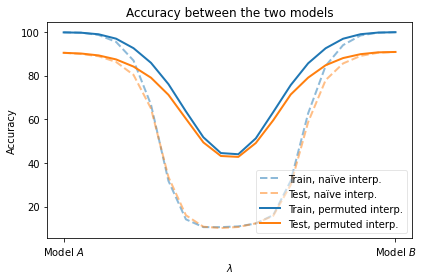

In [9]:
# First we do the basic linear interpolation plot
lambdas = torch.linspace(0, 1, steps=n_points)
fig = plot.plot_interp_metric("accuracy", lambdas, train_acc_naive, test_acc_naive, train_acc_perm, test_acc_perm)

In [10]:
# Now we generate the contour plot
a_params = torch.load("mode_connectivity/model_files/resnet_wm1_a.pt") 
b_params = torch.load("mode_connectivity/model_files/resnet_wm1_b.pt") 
v1, v2, v3 = (
    utils.state_dict_to_numpy_array(p) for p in [a_params, b_params, permuted_params]
)

model_a = ResNet()
model_a.load_state_dict(a_params)

contour_plane = utils.generate_orthogonal_basis(v1, v2, v3)
train_loader, test_loader = data.get_data_loaders(
    dataset="cifar10", train_kwargs={"batch_size":512}, test_kwargs={"batch_size":512}
)
device, _ = get_device()
(
    t1s,
    t2s,
    test_acc_grid,
    test_loss_grid,
    train_acc_grid,
    train_loss_grid,
) = utils.generate_loss_landscape_contour(
    model_a, device, train_loader, test_loader, contour_plane, granularity=10
)

Files already downloaded and verified
Files already downloaded and verified


11it [38:56, 212.45s/it]


In [17]:
np.save('resnet1_train_acc_grid.npy', train_acc_grid)
np.save('resnet1_test_acc_grid.npy', test_acc_grid)
np.save('resnet1_train_loss_grid.npy', train_loss_grid)
np.save('resnet1_test_loss_grid.npy', test_loss_grid)

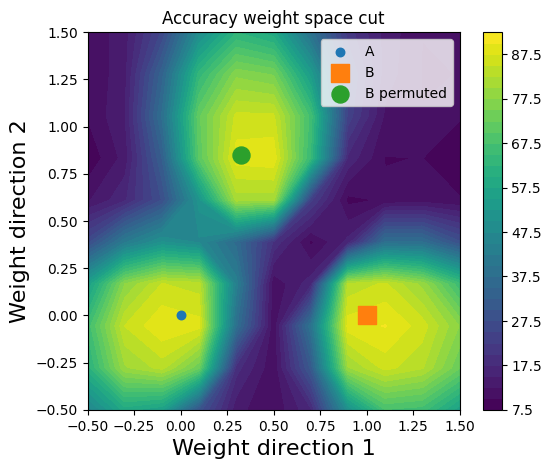

In [18]:
plot.plot_metric_contour(
    "accuracy",
    t1s,
    t2s,
    test_acc_grid,
    model_vectors_dict={
        "A": utils.projection(v1, contour_plane),
        "B": utils.projection(v2, contour_plane),
        "B permuted": utils.projection(v3, contour_plane),
    },
)

# WM=4

In [12]:
n_points = 20
lambdas = torch.linspace(0, 1, steps=n_points)

for wm in [4]:

  (
      permuted_params,
      train_acc_naive,
      test_acc_naive,
      train_acc_perm,
      test_acc_perm,
  ) = linear_mode_connect(
      ResNet, 
      {'width_multiplier': wm},
      f'mode_connectivity/model_files/resnet_wm{wm}_a.pt', 
      f'mode_connectivity/model_files/resnet_wm{wm}_b.pt', 
      'cifar10', 
      n_points=n_points, 
      verbose=2, 
      max_iter=30,
  )

  torch.save(permuted_params, f'mode_connectivity/model_files/resnet_wm{wm}_b_permuted.pt')

  print(train_acc_naive)
  print(test_acc_naive)
  print(train_acc_perm)
  print(test_acc_perm)

Files already downloaded and verified
Files already downloaded and verified

performing naive interpolation
Average loss: 0.0002, Accuracy: (100%)
Average loss: 0.2784, Accuracy: (94%)
point 1/20. lam = 0.0, train loss = 0.00021626579135656358, test loss = 0.2784376403808594
Average loss: 0.0006, Accuracy: (100%)
Average loss: 0.2708, Accuracy: (94%)
point 2/20. lam = 0.05263157933950424, train loss = 0.0005716440504789352, test loss = 0.2707646667480469
Average loss: 0.0024, Accuracy: (100%)
Average loss: 0.2820, Accuracy: (93%)
point 3/20. lam = 0.10526315867900848, train loss = 0.0024140050625801085, test loss = 0.2820044616699219
Average loss: 0.0148, Accuracy: (100%)
Average loss: 0.3240, Accuracy: (92%)
point 4/20. lam = 0.15789473056793213, train loss = 0.014828957920074463, test loss = 0.3240397277832031
Average loss: 0.0843, Accuracy: (97%)
Average loss: 0.4293, Accuracy: (88%)
point 5/20. lam = 0.21052631735801697, train loss = 0.0842717300415039, test loss = 0.42925225830078

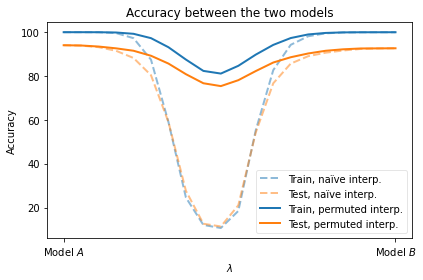

In [19]:
# First we do the basic linear interpolation plot
lambdas = torch.linspace(0, 1, steps=n_points)
fig = plot.plot_interp_metric("accuracy", lambdas, train_acc_naive, test_acc_naive, train_acc_perm, test_acc_perm)

In [22]:
# Now we generate the contour plot
a_params = torch.load("mode_connectivity/model_files/resnet_wm4_a.pt") 
b_params = torch.load("mode_connectivity/model_files/resnet_wm4_b.pt") 
v1, v2, v3 = (
    utils.state_dict_to_numpy_array(p) for p in [a_params, b_params, permuted_params]
)

model_a = ResNet(width_multiplier=4)
model_a.load_state_dict(a_params)

contour_plane = utils.generate_orthogonal_basis(v1, v2, v3)
train_loader, test_loader = data.get_data_loaders(
    dataset="cifar10", train_kwargs={"batch_size":512}, test_kwargs={"batch_size":512}
)
device, _ = get_device()
(
    t1s,
    t2s,
    test_acc_grid,
    test_loss_grid,
    train_acc_grid,
    train_loss_grid,
) = utils.generate_loss_landscape_contour(
    model_a, device, train_loader, test_loader, contour_plane, granularity=10
)

Files already downloaded and verified
Files already downloaded and verified


11it [08:20, 45.54s/it]


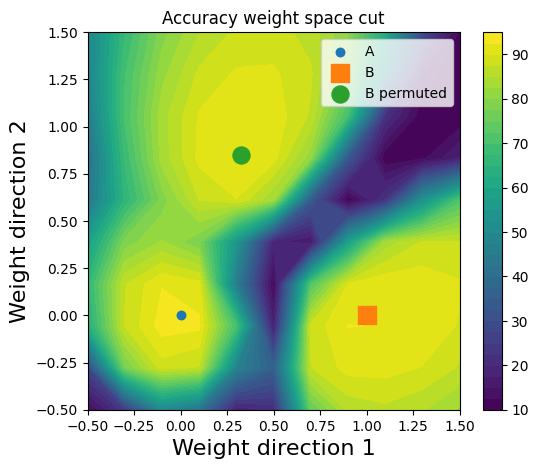

In [23]:
plot.plot_metric_contour(
    "accuracy",
    t1s,
    t2s,
    test_acc_grid,
    model_vectors_dict={
        "A": utils.projection(v1, contour_plane),
        "B": utils.projection(v2, contour_plane),
        "B permuted": utils.projection(v3, contour_plane),
    },
)

In [24]:
np.save('resnet4_test_acc_grid.npy', test_acc_grid)
np.save('resnet4_test_loss_grid.npy', test_loss_grid)